In [126]:
import numpy as np
from matplotlib import pyplot as plt
import drehung
from scipy.special import betainc,spence
from functools import reduce
import sympy

In [127]:
SAMPLE_SIZE=100

VOLUME_SAMPLE=int(5e4)

In [128]:
sample_random=[]
while len(sample_random)<SAMPLE_SIZE:
    sample_new=np.ones((4,4))-2*np.random.random((4,4))
    if not all([np.linalg.norm(i)<1 for i in sample_new]):
        continue
    sample_random.append([i/np.linalg.norm(i) for i in sample_new])

In [172]:
def tetrahedron(x):
    fac=np.sqrt(1-x**2)
    return np.array([[np.sqrt(8/9)*fac,0,-fac/3,x],
                    [-np.sqrt(2/9)*fac,fac*np.sqrt(2/3),-fac/3,x],
                    [-np.sqrt(2/9)*fac,-fac*np.sqrt(2/3),-fac/3,x],
                    [0,0,fac,x]])
def edge_angles(tetra):
    angles=[]
    for i in range(6):
        if i<3:
            vertices=(0,i+1)
        else:
            vertices=[]
            for j in range(1,4):
                if j+2!=i:
                    vertices.append(j)
        space1=[tetra[i] for i in range(4) if i!=vertices[1]]
        space2=[tetra[i] for i in range(4) if i!=vertices[0]]
        intersection=drehung.orthonormalisierung(drehung.schnitt(space1,space2))
        vec1=drehung.orthonormalisierung(np.concatenate((intersection,space1)))[2]
        vec2=drehung.orthonormalisierung(np.concatenate((intersection,space2)))[2]
        angles.append(np.acos(vec1@vec2))
    return angles
def pointiness(tetra):
    pointiness=8*np.pi
    for p1 in range(4):
        for p2 in range(4):
            if p1==p2:
                continue
            p3=(p2+1)%4
            if p3==p1:
                p3=(p3+1)%4
            vec1=tetra[p2]-tetra[p1]*(tetra[p2]@tetra[p1])
            vec1/=np.linalg.norm(vec1)
            vec2=tetra[p3]-tetra[p1]*(tetra[p3]@tetra[p1])
            vec2/=np.linalg.norm(vec2)
            angle=np.acos(vec1@vec2)
            pointiness-=angle
    return pointiness
def volume_alt(tetra,depth=0):
    if depth==0:
        return abs(np.linalg.det(drehung.orthonormalisierung([(x-tetra[0]) for x in tetra[1:]])@np.array([x-tetra[0] for x in tetra[1:]]).T))/6
    points_new=[]
    for i in range(3):
        for j in range(i+1,4):
            points_new.append((tetra[i]+tetra[j])/np.linalg.norm(tetra[i]+tetra[j]))
    points_indices=[[0,1,2],[0,3,4],[1,3,5],[2,4,5]]
    points_split=[[0,1,2,5],[0,3,4,5],[0,1,3,5],[0,2,4,5]]
    volume_total=0
    for i in range(4):
        tetra_new=[np.copy(tetra[i])]
        for j in points_indices[i]:
            tetra_new.append(np.copy(points_new[j]))
        volume_total+=volume_alt(tetra_new,depth-1)
    for indices in points_split:
        tetra_new=[np.copy(points_new[i]) for i in indices]
        volume_total+=volume_alt(tetra_new,depth-1)
    return volume_total
def area_alt(tri,depth=0):
    if depth==0:
        return abs(np.linalg.det(drehung.orthonormalisierung([(x-tri[0]) for x in tri[1:]])@np.array([x-tri[0] for x in tri[1:]]).T))/2
    points_new=[]
    for i in range(3):
        points_new.append((tri[i]+tri[(i+1)%3])/np.linalg.norm(tri[i]+tri[(i+1)%3]))
    volume_total=area_alt(points_new,depth-1)
    for i in range(3):
        volume_total+=area_alt([tri[i],points_new[i],points_new[(i+2)%3]],depth-1)
    return volume_total
def length_alt(bi,depth=0):
    if depth==0:
        return abs(np.linalg.det(drehung.orthonormalisierung([(x-bi[0]) for x in bi[1:]])@np.array([x-bi[0] for x in bi[1:]]).T))/1
    point_new=sum(bi)/np.linalg.norm(sum(bi))
    volume_total=0
    for i in range(2):
        bi_new=[np.copy(point_new)]
        for j in range(2):
            if j==i:
                continue
            bi_new.append(np.copy(bi[j]))
        bi_new=np.array(bi_new)
        volume_total+=length_alt(bi_new,depth-1)
    return volume_total

In [174]:
volume_alt(tetrahedron(0.1),5)

np.float64(7.405728006313303)

In [157]:
#tetra=tetrahedron(0.9)
for i in range(6):
    print(i,volume_alt(np.eye(4),i))

0 0.3333333333333333
1 0.7614924984194124
2 1.078902475970103
3 1.2020959060457723
4 1.2334101789543785
5 1.238682148156259


In [108]:
pointinesses=[pointiness(tetra) for tetra in sample_random]
angle_sums=[sum(edge_angles(tetra)) for tetra in sample_random]

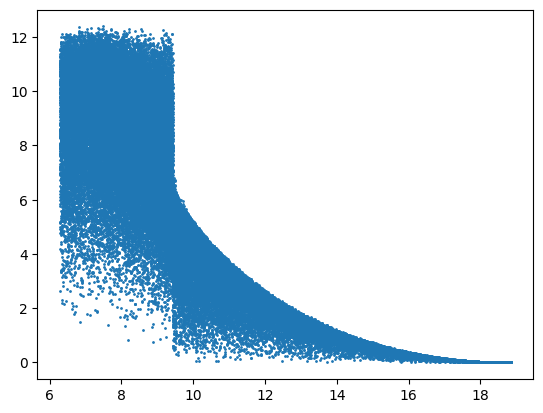

In [120]:
plt.scatter(angle_sums,[(p if angle_sums[i]<3*np.pi else p) for (i,p) in enumerate(pointinesses)],s=1)

In [85]:
volume_alt(tetrahedron(0.99),1)

np.float64(0.0014728943427333736)

In [137]:
tetra=np.array([[1,0,0,0],
                [0,0,1,0],
                [0,1,0,0],
                [-np.sqrt(2)/2,-np.sqrt(2)/2,0,0]])
for p in tetra[1:]:
    print(p-tetra[0]*(p@tetra[0]))
pointiness(tetra)

[0. 0. 1. 0.]
[0. 1. 0. 0.]
[ 0.         -0.70710678  0.          0.        ]


np.float64(0.0)

In [162]:
x_sample=[0.1,0.01,0.001]
volumes=[]
pointinesses=[]
for x in x_sample:
    tetra=tetrahedron(x)

    pointsIn=0
        
    for _ in range(VOLUME_SAMPLE):
        point=np.ones((1,4))
        while np.linalg.norm(point)>1:
            point=np.ones((1,4))-2*np.random.random((1,4))
        point/=np.linalg.norm(point)
        inside=True
        for i in range(len(tetra)):
            vecs=np.copy(tetra)
            
            a=np.copy(vecs[3])
            vecs[3]=np.copy(vecs[i])
            vecs[i]=a
        
            vecs=drehung.orthonormalisierung(vecs)
        
            if(point@vecs[3]<0):
                inside=False
                break
        pointsIn+=inside
    volumes.append(pointsIn/VOLUME_SAMPLE)
    pointinesses.append(pointiness(tetra))

In [130]:
volumes_random=[]
pointinesses_random=[]
for tetra in sample_random:
    pointsIn=0
    
    for _ in range(VOLUME_SAMPLE):
        point=np.ones((1,4))
        while np.linalg.norm(point)>1:
            point=np.ones((1,4))-2*np.random.random((1,4))
        point/=np.linalg.norm(point)
        inside=True
        for i in range(len(tetra)):
            if(point@tetra[i]<0):
                inside=False
                break
            continue
            vecs=np.copy(tetra)
            a=np.copy(vecs[3])
            vecs[3]=np.copy(vecs[i])
            vecs[i]=a
            vecs=drehung.orthonormalisierung(vecs)
            if(point@vecs[3]<0):
                inside=False
                break
        pointsIn+=inside
    volume=pointsIn/VOLUME_SAMPLE
    volumes_random.append(volume)
    pointinesses_random.append(pointiness(tetra))


In [176]:
volumes_random=[]
pointinesses_random=[]
for tetra in sample_random:
    volumes_random.append(volume_alt(tetra,5))
    pointinesses_random.append(pointiness(tetra))

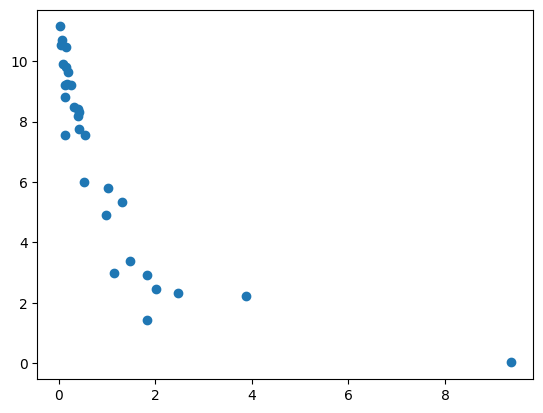

In [177]:
#plt.scatter(np.linspace(0,0.5,100),[np.pi/2-4*x for x in np.linspace(0,0.5,100)])
plt.scatter(volumes_random,pointinesses_random)

#plt.scatter(volumes,pointinesses)

In [182]:
indices=[]
for i in range(100):
    if pointinesses_random[i]<=0.3+np.pi/2-4*(volumes_random[i]):
        indices.append(i)

In [186]:
for i in range(1,4):
    for j in range(i):
        print(np.linalg.norm(sample_random[22][i]-sample_random[22][j]))

0.7860744091910968
1.8629812637102579
1.7917434270332404
1.4619383431629387
1.833397183804176
1.5126680029091708


In [192]:
basis=drehung.orthonormalisierung([(x-sample_random[22][0]) for x in sample_random[22][1:]])

[0, 9, 16, 19, 33, 37, 41, 59, 67, 75, 80, 84]


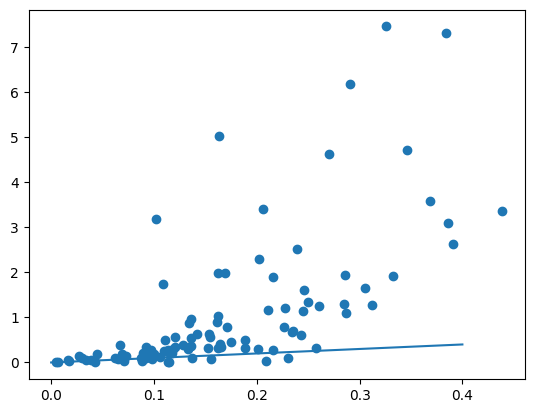

In [101]:
to_be_plotted=[]
list_p=[]
for (i,tetra) in enumerate(sample_random):
    volume_sphere=2*np.pi**2*volumes_random[i]
    volume_euclidean=abs(np.linalg.det((drehung.orthonormalisierung([(x-tetra[0]) for x in tetra[1:]])@np.array([x-tetra[0] for x in tetra[1:]]).T).T))/6
    if(volume_euclidean>volume_sphere):
        list_p.append(i)
    to_be_plotted.append(volume_euclidean)
print(list_p)
plt.scatter(to_be_plotted,np.array(volumes_random)*2*np.pi**2)
plt.plot(np.linspace(0,0.4,10000),np.linspace(0,0.4,10000))

In [166]:
tetra=np.array([[-0.39523161,  0.01009799, -0.83890196, -0.37407688],
 [-0.47322503, -0.77072094, -0.38610615,  0.18157462],
 [ 0.21912495,  0.68256777,  0.50469275, -0.4810101 ],
 [-0.46444691, -0.55448441,  0.55008444, -0.41742451]])

In [167]:
for i in range(8):  
    print(i,volume_alt(tetra,i))

0 0.1951489601688012
1 0.1951489601688013
2 0.1951489601688013
3 0.19514896016880123
4 0.19514896016880123
5 0.19514896016880123
6 0.19514896016880123


KeyboardInterrupt: 

In [ ]:

def get_tetra(x):
    
    dir_ortho=drehung.orthogonal_raum([tetra[i]-tetra[0] for i in range(1,4)])
    tetra+=(np.ones((4,1))*x)@dir_ortho-tetra@dir_ortho.T@dir_ortho


In [135]:
pointsIn=0
    
for _ in range(int(1e5)):
    point=np.ones((1,4))
    while np.linalg.norm(point)>1:
        point=np.ones((1,4))-2*np.random.random((1,4))
    point/=np.linalg.norm(point)
    inside=True
    for i in range(len(tetra)):
        #if(point@tetra[i]<0):
        #    inside=False
        #    break
        #continue
        vecs=np.copy(tetra)
        face=drehung.orthonormalisierung([vec for (j,vec) in enumerate(vecs) if j!=i])
        vec_ortho=vecs[i]-face.T@face@vecs[i]
        if(point@vec_ortho<0):
            inside=False
            break
    pointsIn+=inside
pointsIn/1e5*np.pi**2*2

0.10560476709165613

In [122]:
basis=drehung.orthonormalisierung([(x-tetra[0]) for x in tetra[1:]])
tetra_3d=(drehung.orthonormalisierung([(x-tetra[0]) for x in tetra[1:]])@np.array([x-tetra[0] for x in tetra[1:]]).T).T

In [124]:
np.linalg.det(tetra_3d)/6

np.float64(0.1951489601688012)

In [83]:
point_new=sum(tetra)/4
print(np.linalg.norm(point_new))
point_new/=np.linalg.norm(point_new)
volume_total=0
for i in range(4):
    tetra_new=[np.copy(point_new)]
    for j in range(4):
        if j==i:
            continue
        tetra_new.append(np.copy(tetra[j]))
    tetra_new=np.array(tetra_new)
    volume_total+=abs(np.linalg.det(drehung.orthonormalisierung([(x-tetra_new[0]) for x in tetra_new[1:]])@np.array([x-tetra_new[0] for x in tetra_new[1:]]).T))/6
volume_total

0.4227684732271974


np.float64(0.5211152622454224)

In [70]:
def inner_radius(tetra):
    dir_ortho=drehung.orthogonal_raum([tetra[i]-tetra[0] for i in range(1,4)])
    dist_min=None
    for i in range(4):
        face=[tetra[j] for j in range(4) if j!=i]
        offset=np.copy(face[0])
        face=[face[j]-offset for j in range(1,3)]

        offset-=dir_ortho.T@dir_ortho@offset
        face=drehung.orthonormalisierung(face)
        dist=np.linalg.norm(offset-face.T@face@offset)
        if dist_min==None or dist<dist_min:
            dist_min=dist
    return dist_min

In [75]:
inner_radius(tetra)

np.float64(0.12453250027935393)

In [76]:
def volume_lower_bound(r):
    h=1-np.sqrt(1-r**2)
    return np.pi**2*betainc(3/2,1/2,2*h-h**2)

In [77]:
volume_lower_bound(inner_radius(tetra))

np.float64(0.008127733994674246)

In [25]:
a=drehung.orthonormalisierung(np.array([[1,2,0],
                                        [2,1,0]]))
b=np.array([1,2,3])

array([1., 2., 0.])

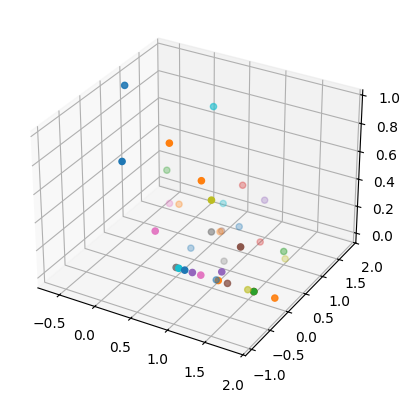

In [102]:
fig=plt.figure()
ax=fig.add_subplot(projection='3d')
#tetra_3d=np.concatenate((tetra_3d,np.zeros((1,3))))
#ax.scatter(tetra_3d[:,0],tetra_3d[:,1],tetra_3d[:,2])
for i in [0, 9, 16, 19, 33, 37, 41, 59, 67, 75, 80, 84]:
    obj=(drehung.orthonormalisierung([(x-sample_random[i][0]) for x in sample_random[i][1:]])@np.array([x-sample_random[i][0] for x in sample_random[i][1:]]).T).T
    ax.scatter(obj[:,0],obj[:,1],obj[:,2])

In [97]:
def L(z,alph):
    def help_me(nums,neg=False):
        return spence(z*reduce(lambda x,y:x*y,[1/alph[i] for i in nums])*(-1 if neg else 1))
    return 0.5*(spence(z)+help_me([0,1,3,4])+help_me([0,2,3,5])+help_me([1,2,4,5])-help_me([0,1,2],True)-help_me([0,4,5],True)-help_me([1,3,5],True)-help_me([2,3,4],True)+sum([np.log(alph[i]*alph[i+3]) for i in range(3)]))

def V_sphere(tetra):
    angles=edge_angles(tetra)
    print(angles)
    alph=[np.exp(1j*angle) for angle in angles]
    q_0=alph[0]*alph[3]+alph[1]*alph[4]+alph[2]*alph[5]+alph[0]*alph[1]*alph[5]+alph[0]*alph[2]*alph[4]+alph[1]*alph[2]*alph[3]+alph[3]*alph[4]*alph[5]+alph[0]*alph[1]*alph[2]*alph[3]*alph[4]*alph[5]
    q_1=-(alph[0]-1/alph[0])*(alph[3]-1/alph[3])-(alph[1]-1/alph[1])*(alph[4]-1/alph[4])-(alph[2]-1/alph[2])*(alph[5]-1/alph[5])
    q_2=1/(alph[0]*alph[3])+1/(alph[1]*alph[4])+1/(alph[2]*alph[5])+1/(alph[0]*alph[1]*alph[5])+1/(alph[0]*alph[2]*alph[4])+1/(alph[1]*alph[2]*alph[3])+1/(alph[3]*alph[4]*alph[5])*1/(alph[0]*alph[1]*alph[2]*alph[3]*alph[4]*alph[5])

    z_0=(-q_1+np.sqrt(q_1**2-4*q_0*q_2))/(2*q_2)
    return (-L(z_0,alph).real+np.pi*(0.5*sum(angles)+np.log(-q_2).imag)-1.5*np.pi**2)%(2*np.pi**2)

In [96]:
V_sphere(tetrahedron(0.2))

[np.float64(2.2605713275803963), np.float64(2.2605713275803963), np.float64(2.2605713275803963), np.float64(2.2605713275803963), np.float64(2.2605713275803963), np.float64(2.2605713275803963)]


np.float64(16.196201815170863)